In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs
import intake
import intake_esm

In [4]:
import os
os.chdir('/home/jovyan/signal-extraction/gcm_vae')

In [3]:
os.getcwd()

'/home/jovyan/signal-extraction/gcm_vae'

## Selecting and Loading the GCM data. 

In [ ]:
# Loading the Pangeo CMIP catalog from Google Cloud:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
col 

>**note** I chose to use the E3SM-1-1 model for consistency with Passarrella and Mahajan. I believe that they used E3SM-1-0, but I have chosen to go with E3SM-1-1 because it is an improved version and will accordingly offer more relevant results. 

In [ ]:
# Querying the catalog for both E3SM-1-1 precipitation and SST
gcm_pr_tos_mon = col.search(
    experiment_id=['historical'],
    source_id=['E3SM-1-1'],
    variable_id=['pr', 'tos'],       # <- select both
)

# Turn into dataset dictionary
gptd_dict = gcm_pr_tos_mon.to_dataset_dict(
    xarray_open_kwargs=dict(use_cftime=True),
    aggregate=False
)

In [ ]:
import xarray as xr

# Extract the tos and pr datasets
sstdat = [ds for key, ds in gptd_dict.items() if "tos" in key][0]
prdat  = [ds for key, ds in gptd_dict.items() if "pr"  in key][0]


In [ ]:
print(list(gptd_dict.keys()))

## Implementing the MIMO-AE

In [5]:
from mimovae_stable import *

> **note** The sst and pr data needs to be clipped before the model is run. Below I clip the data to the Nino 3.4 region and my case study area, respectively. Note that the E3SM data is a $1^{\circ}\times1^{\circ}$ grid with centers beginning at $0.5^{\circ}$, so it is slightly shifted from the reanalysis data.

In [ ]:
sdat1 = sstdat.sel(
    lon=slice(189.5, 240.5),
    lat=slice(-5.5, 5.5)  # descending order is fine, xarray handles it
)

print(sdat1)

In [ ]:
sstdat['tos'].mean().values

In [ ]:
pdat1 = prdat.sel(
    lon=slice(237.5, 241.5),
    lat=slice(35.5, 40.5)  # descending order is fine, xarray handles it
)

print(pdat1)

> **note** The data also needs to undergo some preprocessing to make it consistent with my reanalysis results. 

In [ ]:
pdat1['pr']= pdat1['pr'] * 86400 * pdat1.time.dt.days_in_month

print(pdat1['pr'].mean().values)
print(prdat['pr'].mean().values)

In [ ]:
print(pdat1.dims)

In [ ]:
pdat1 = pdat1['pr'].squeeze().transpose('time', 'lat', 'lon')
print(pdat1.dims)

In [ ]:
print(sdat1.dims)

In [ ]:
print(sdat1)

In [ ]:
sdat1 = sdat1['tos'].squeeze().transpose('time','lat','lon')
print(sdat1.dims)

>**note** Here I save the preprocessed files as netcdfs so that I can clear up some of the memory and for reproducibility.

```python
sdat1.to_netcdf("E3SM-1-1_mon-mean-tos_clipped_cleaned.nc")
pdat1.to_netcdf("E3SM-1-1_mon-sum-pr_clipped_cleaned.nc")
```

>**note** Now, I believe that we are ready to run the model :)

In [6]:
sdata1 = xr.open_dataset("E3SM-1-1_mon-mean-tos_clipped_cleaned.nc")
pdata1 = xr.open_dataset("E3SM-1-1_mon-sum-pr_clipped_cleaned.nc")

In [8]:
m1 = learn(sdata1,pdata1,"minmax",'tos','pr', 0.8, 32)

/home/jovyan/signal-extraction/gcm_vae/mimovae_stable.py:322: RuntimeWarning: overflow encountered in square
  (inverse_transform(precip_scaler, precip_recon) -
/home/jovyan/signal-extraction/gcm_vae/mimovae_stable.py:322: RuntimeWarning: overflow encountered in square
  (inverse_transform(precip_scaler, precip_recon) -
/home/jovyan/signal-extraction/gcm_vae/mimovae_stable.py:322: RuntimeWarning: overflow encountered in square
  (inverse_transform(precip_scaler, precip_recon) -
/home/jovyan/signal-extraction/gcm_vae/mimovae_stable.py:322: RuntimeWarning: overflow encountered in square
  (inverse_transform(precip_scaler, precip_recon) -
/home/jovyan/signal-extraction/gcm_vae/mimovae_stable.py:322: RuntimeWarning: overflow encountered in square
  (inverse_transform(precip_scaler, precip_recon) -
/home/jovyan/signal-extraction/gcm_vae/mimovae_stable.py:322: RuntimeWarning: overflow encountered in square
  (inverse_transform(precip_scaler, precip_recon) -
/home/jovyan/signal-extraction/gcm

In [9]:
from mimovae_stable import train_summary

In [16]:
train_summary(m1,'gcm_vae_training_summary')

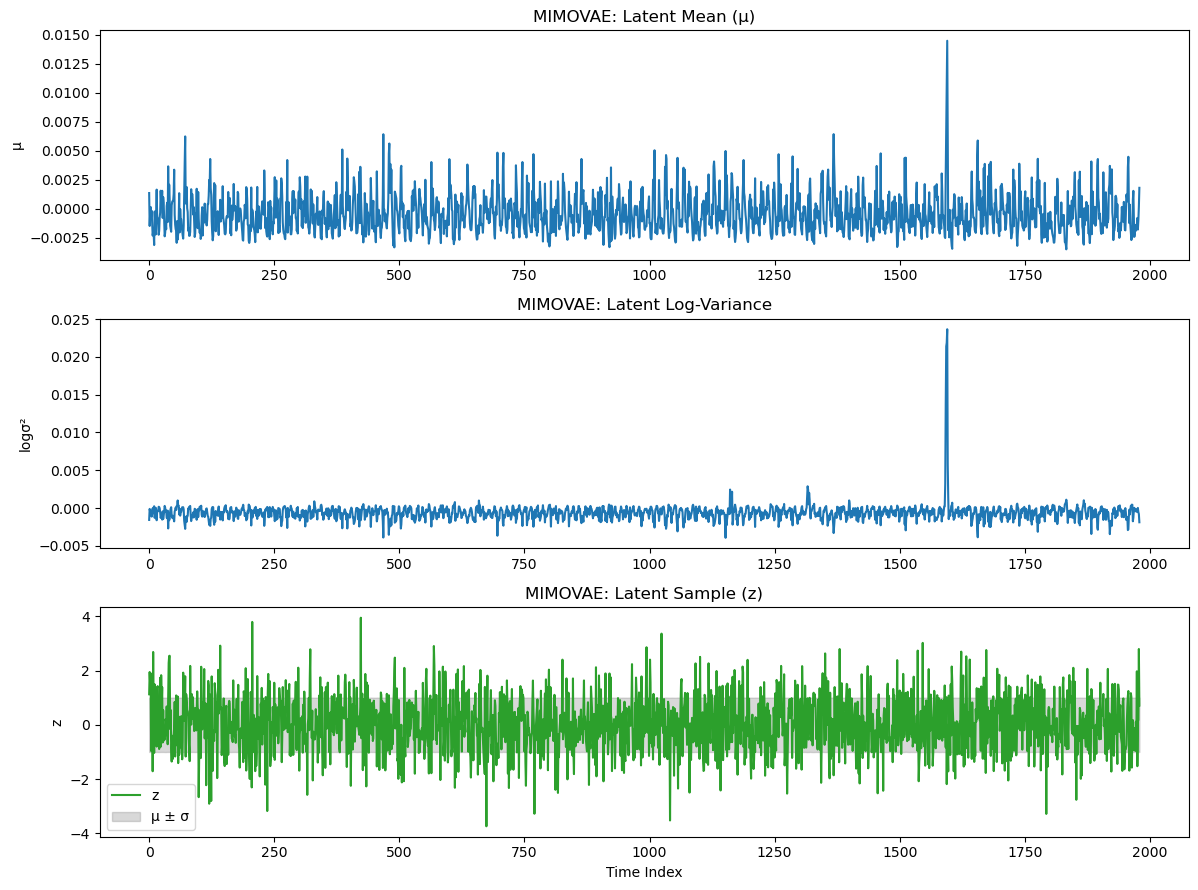

In [17]:
e1 = extractr(m1['model'],sdata1,'tos',pdata1,'pr',m1['sst_scaler'],m1['precip_scaler'],True,True,"E3SM-1-1_vae_extractr_results")